In [ ]:
#!pip uninstall pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e5359a40db3c85fe3af02b412c615eb60214bacbefb5f3a78bb41897989c6943
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162993 sha256=4bc1158d897ea4727af52cbaa76fd2dd742d3d0eb6ceeda4a656ff0c3f5b604b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, lit

In [ ]:
spark = SparkSession.builder.appName("MovieLensRecomendacionSVD").getOrCreate()

# Cargar datos
df_ratings = spark.read.csv("/rating.csv", header=True, inferSchema=True)
df_movies = spark.read.csv("/movie.csv", header=True, inferSchema=True)

In [ ]:
Ratings = df_ratings.join(df_movies, on="movieId", how="inner")

In [ ]:
Ratings

DataFrame[movieId: int, userId: int, rating: double, timestamp: timestamp, title: string, genres: string]

# EDA

Descripción de los Datos

In [ ]:
# Convertir a DataFrame de pandas para EDA
Ratings_Pandas = Ratings.toPandas()

In [ ]:
# Convertir a DataFrame de pandas para EDA
Ratings_Pandas = Ratings.toPandas()

# Ver las primeras filas del DataFrame
print(Ratings_Pandas.head())

# Descripción del DataFrame
print(Ratings_Pandas.describe())

# Información del DataFrame
print(Ratings_Pandas.info())


   movieId  userId  rating           timestamp  \
0        2       1     3.5 2005-04-02 23:53:47   
1       29       1     3.5 2005-04-02 23:31:16   
2       32       1     3.5 2005-04-02 23:33:39   
3       47       1     3.5 2005-04-02 23:32:07   
4       50       1     3.5 2005-04-02 23:29:40   

                                               title  \
0                                     Jumanji (1995)   
1  City of Lost Children, The (Cité des enfants p...   
2          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3                        Seven (a.k.a. Se7en) (1995)   
4                         Usual Suspects, The (1995)   

                                   genres  
0              Adventure|Children|Fantasy  
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
2                 Mystery|Sci-Fi|Thriller  
3                        Mystery|Thriller  
4                  Crime|Mystery|Thriller  
            movieId        userId        rating                      timestamp
count  1.327183e+06

Distribución de las Calificaciones
Visualizamos la distribución de las calificaciones.

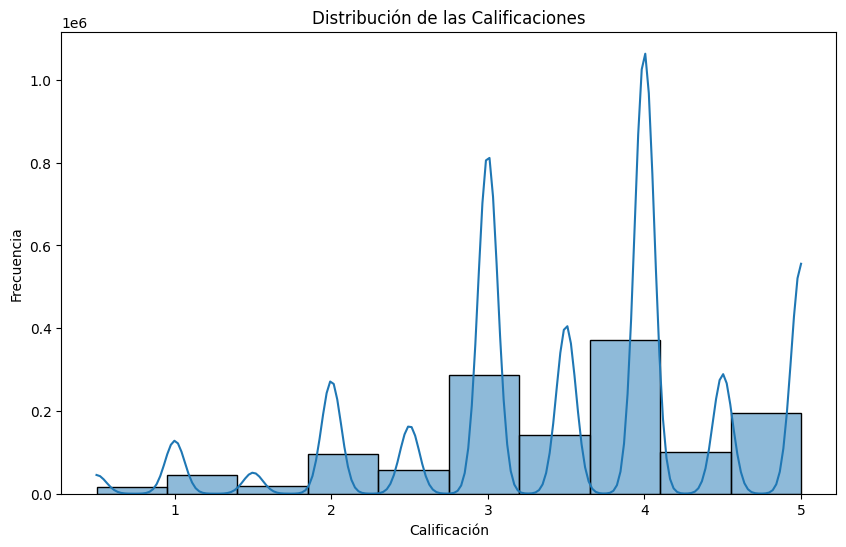

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(Ratings_Pandas['rating'], bins=10, kde=True)
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()


 Número de Calificaciones por Película
Identificamos las películas con más calificaciones.

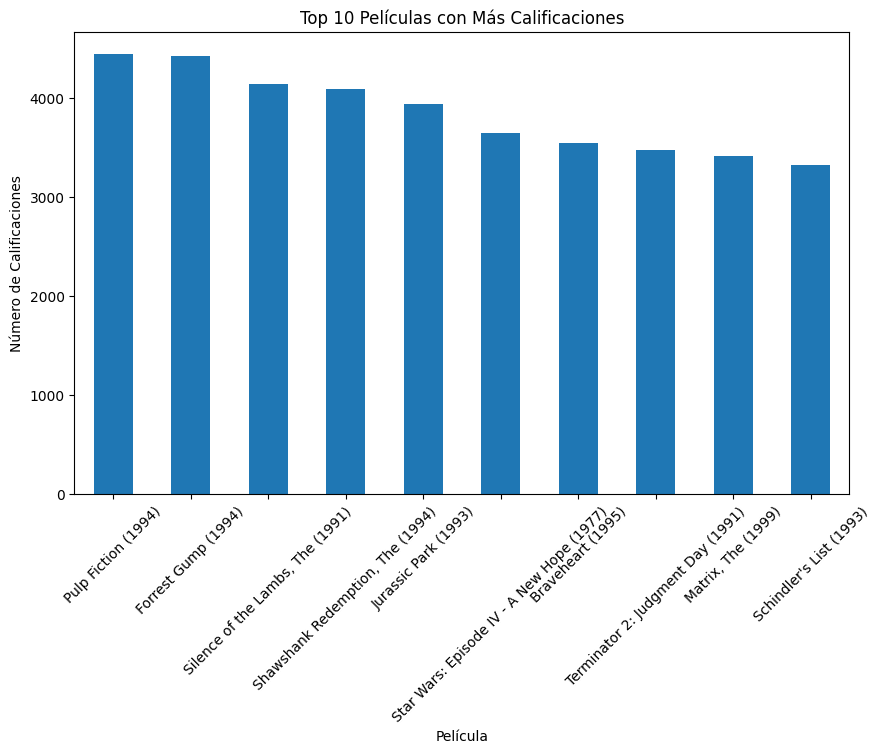

In [ ]:
ratings_per_movie = Ratings_Pandas.groupby('title').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
ratings_per_movie.plot(kind='bar')
plt.title('Top 10 Películas con Más Calificaciones')
plt.xlabel('Película')
plt.ylabel('Número de Calificaciones')
plt.xticks(rotation=45)
plt.show()


Calificación Promedio por Película

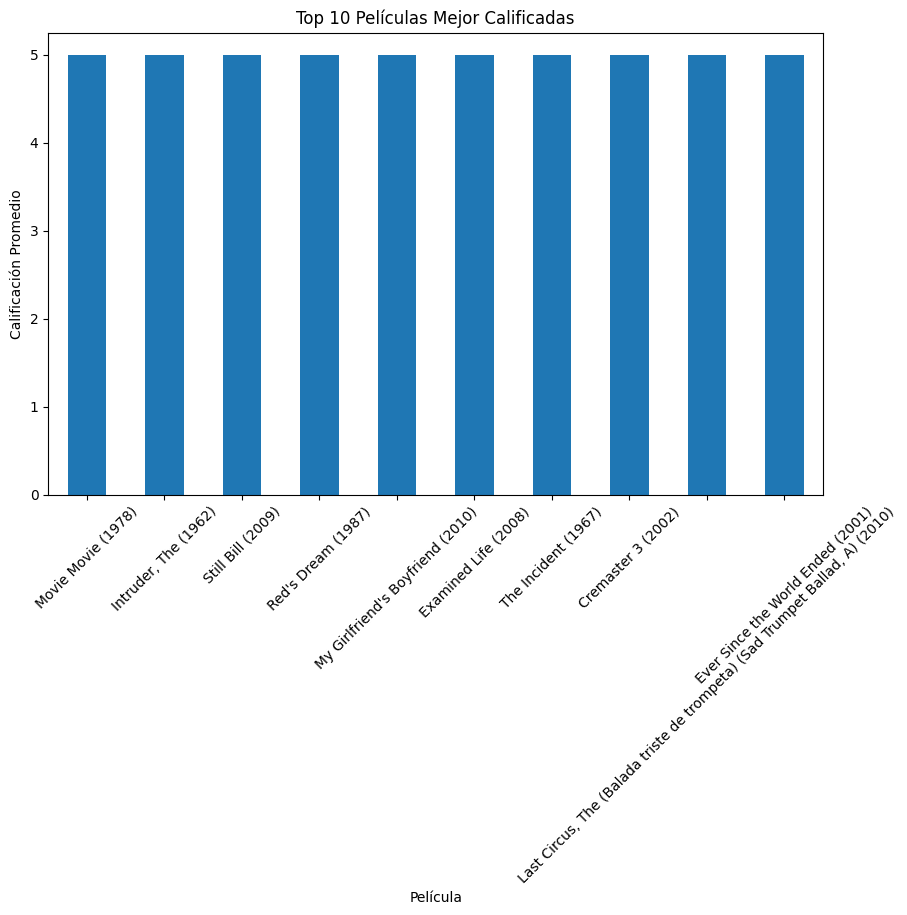

In [ ]:
average_ratings = Ratings_Pandas.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
average_ratings.plot(kind='bar')
plt.title('Top 10 Películas Mejor Calificadas')
plt.xlabel('Película')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45)
plt.show()


Número de Calificaciones por Usuario

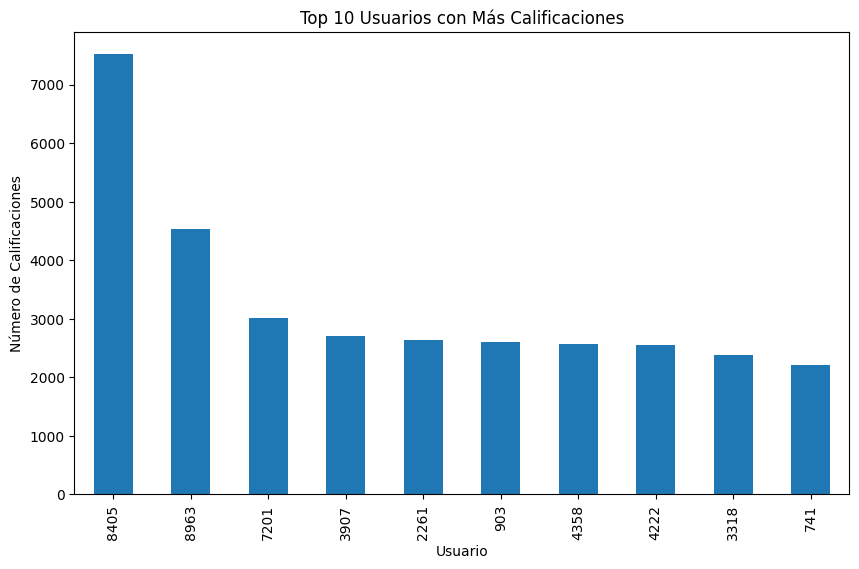

In [ ]:
ratings_per_user = Ratings_Pandas.groupby('userId').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
ratings_per_user.plot(kind='bar')
plt.title('Top 10 Usuarios con Más Calificaciones')
plt.xlabel('Usuario')
plt.ylabel('Número de Calificaciones')
plt.show()

Relación Entre Calificaciones y Géneros

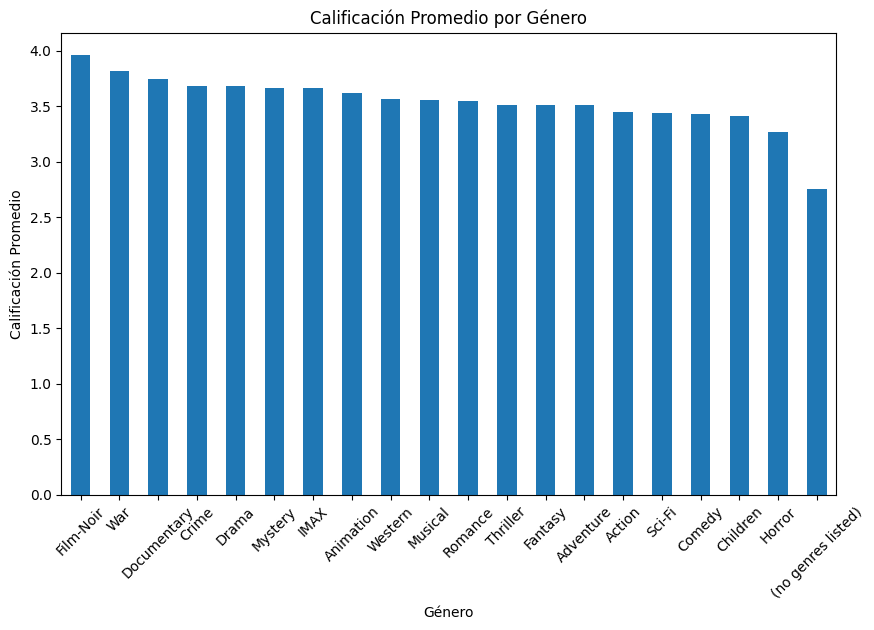

In [ ]:
# Convertir la columna de géneros a una lista
Ratings_Pandas['genres'] = Ratings_Pandas['genres'].apply(lambda x: x.split('|'))

# Expandir los géneros en filas separadas
df_genres = Ratings_Pandas.explode('genres')

# Calificación promedio por género
average_rating_genres = df_genres.groupby('genres')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
average_rating_genres.plot(kind='bar')
plt.title('Calificación Promedio por Género')
plt.xlabel('Género')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45)
plt.show()

Número de Películas por Género

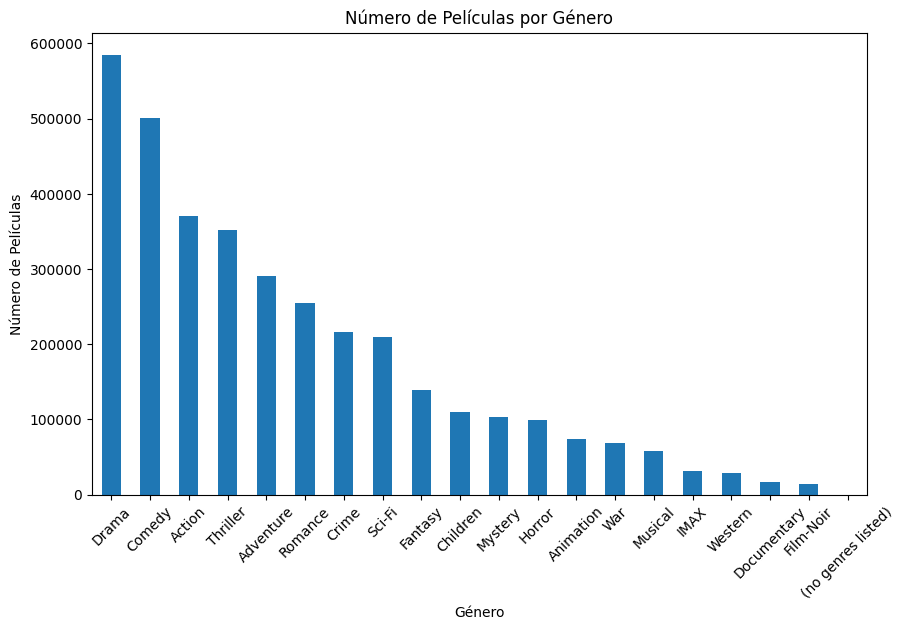

In [ ]:
num_movies_genres = df_genres['genres'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
num_movies_genres.plot(kind='bar')
plt.title('Número de Películas por Género')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_genres

,movieId,userId,rating,timestamp,title,genres
0,2,1,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure
0,2,1,3.5,2005-04-02 23:53:47,Jumanji (1995),Children
0,2,1,3.5,2005-04-02 23:53:47,Jumanji (1995),Fantasy
1,29,1,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure
1,29,1,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Drama
...,...,...,...,...,...,...
1327181,1262,9032,4.0,2003-09-16 10:43:55,"Great Escape, The (1963)",Adventure
1327181,1262,9032,4.0,2003-09-16 10:43:55,"Great Escape, The (1963)",Drama
1327181,1262,9032,4.0,2003-09-16 10:43:55,"Great Escape, The (1963)",War
1327182,1263,9032,4.0,2013-09-28 15:14:11,"Deer Hunter, The (1978)",Drama


In [ ]:
# División de los datos en tres partes: entrenamiento (60%), prueba (20%) y nuevos individuos (20%)
(training, test, new_individuals) = Ratings.randomSplit([0.6, 0.2, 0.2])

# Preparar los datos para el algoritmo de ALS
ratings = Ratings.select("userId", "movieId", "rating")

Algoritmo ALS (Alternating Least Squares)
ALS es un método utilizado para construir modelos de recomendación basados en la factorización matricial. Este algoritmo se utiliza para predecir las calificaciones de los usuarios a los ítems (películas en este caso) que aún no han calificado. El objetivo es encontrar dos matrices de menor dimensión (una para usuarios y otra para ítems) que, cuando se multiplican, aproximan la matriz original de calificaciones.

Pasos del Algoritmo ALS:
Inicialización:

Se inicia con una matriz de calificaciones donde los usuarios están en las filas y los ítems en las columnas.
Factorización:

ALS descompone la matriz de calificaciones en dos matrices más pequeñas: una matriz de usuarios y una matriz de ítems.
La descomposición se hace de tal manera que la multiplicación de estas dos matrices aproxima la matriz original de calificaciones.
Alternating Least Squares:

ALS alterna entre la actualización de las matrices de usuarios y de ítems, minimizando el error cuadrático medio (RMSE) entre las calificaciones predichas y las calificaciones reales.
Se realiza una optimización iterativa hasta que se alcanza la convergencia o se llega al número máximo de iteraciones.
Predicción:

Una vez entrenado el modelo, se utiliza para predecir calificaciones de ítems que los usuarios no han calificado.

In [ ]:
# Entrenar el modelo ALS
als = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

# Evaluar el modelo en el conjunto de prueba
predictions = model.transform(test)

# Calcular RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9380839392216309


In [ ]:
# Predecir calificaciones para nuevos individuos
new_predictions = model.transform(new_individuals)

# Evaluar el modelo en los nuevos individuos
new_rmse = evaluator.evaluate(new_predictions)
print("RMSE for new individuals = " + str(new_rmse))

RMSE for new individuals = 0.9370121367274102


Interpretación
Consistencia: Los valores de RMSE son similares para el conjunto de prueba y los nuevos individuos, lo que sugiere que el modelo tiene un rendimiento consistente y generaliza bien a datos nuevos.
Precisión del Modelo: Un RMSE de alrededor de 0.937-0.938 es razonablemente bueno para un modelo de recomendación en un contexto donde las calificaciones están en una escala de 1 a 5. Sin embargo, siempre hay espacio para mejorar el modelo, ajustando parámetros, probando diferentes técnicas de preprocesamiento o utilizando otros algoritmos de recomendación.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Convertir las calificaciones a categorías binarias
def get_binary_predictions(predictions, threshold=3.5):
    binary_predictions = []
    for row in predictions.collect():
        binary_predictions.append((row['userId'], row['movieId'], 1 if row['prediction'] >= threshold else 0, 1 if row['rating'] >= threshold else 0))
    return binary_predictions

# Obtener predicciones binarias
binary_predictions = get_binary_predictions(new_predictions)

# Extraer etiquetas verdaderas y predichas
y_true = [pred[3] for pred in binary_predictions]
y_pred = [pred[2] for pred in binary_predictions]

# Calcular precision, recall y F1
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.7917549356009747
Recall: 0.7123031496062993
F1 Score: 0.7499305244812888


Análisis de Resultados
Precisión Alta: Una precisión de ~79.18% sugiere que el modelo es bastante bueno para identificar películas que los usuarios realmente disfrutarán (minimizando falsos positivos).

Recall Moderado: Un recall de ~71.23% indica que el modelo puede encontrar la mayoría de las películas que los usuarios disfrutarán, aunque hay espacio para mejorar (minimizando falsos negativos).

Buen Equilibrio: El F1 score de ~0.75 muestra que el modelo tiene un buen equilibrio entre precisión y recall, lo que es crucial para aplicaciones de recomendación donde tanto la exactitud como la exhaustividad son importantes.

In [ ]:
# Convertir a DataFrame de pandas
df_pandas = Ratings.toPandas()

In [ ]:
df_pandas

,movieId,userId,rating,timestamp,title,genres
0,2,1,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,29,1,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,32,1,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,47,1,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,1,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
917765,32,6128,3.0,1996-06-14 10:42:50,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
917766,34,6128,5.0,1996-06-14 10:42:30,Babe (1995),Children|Drama
917767,36,6128,5.0,1996-06-14 10:46:08,Dead Man Walking (1995),Crime|Drama
917768,39,6128,5.0,1996-06-14 10:43:09,Clueless (1995),Comedy|Romance


In [ ]:
pandas = df_pandas[['userId', 'movieId', 'rating']]

In [ ]:
pandas

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
917765,6128,32,3.0
917766,6128,34,5.0
917767,6128,36,5.0
917768,6128,39,5.0


# SVD

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

¿Qué es SVD?
La Descomposición en Valores Singulares es una forma de descomponer una matriz en tres otras matrices

Reducción Dimensional:

SVD se puede utilizar para reducir la dimensionalidad de los datos, reteniendo solo los componentes más importantes.

En los sistemas de recomendación, SVD se usa para la factorización de la matriz de calificaciones, lo que permite predecir las calificaciones faltantes y hacer recomendaciones.

Entrenamiento:

La matriz de calificaciones (usuarios vs. productos) se descompone utilizando SVD.
Esto produce matrices que relacionan a los usuarios con factores latentes y productos con los mismos factores latentes.

Predicción:

Para predecir la calificación que un usuario dará a un producto, se multiplica la matriz de usuarios con la matriz de productos a través de los factores latentes.
La descomposición permite capturar las similitudes entre usuarios y productos en un espacio de características de menor dimensión.

In [ ]:

from sklearn.model_selection import train_test_split

# Dividir el DataFrame en conjuntos de entrenamiento, prueba y nuevos individuos
train, temp = train_test_split(pandas, test_size=0.4, random_state=42)
test, new_individuals = train_test_split(temp, test_size=0.5, random_state=42)

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Preparar los datos para Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

# Crear el trainset para Surprise
trainset = train_data.build_full_trainset()

# Entrenar el modelo SVD
algo = SVD()
algo.fit(trainset)

In [ ]:
from surprise import Dataset, Reader

# Convertir el DataFrame de nuevos individuos a Surprise dataset
new_data = Dataset.load_from_df(new_individuals[['userId', 'movieId', 'rating']], reader)
new_testset = new_data.construct_testset(new_data.raw_ratings)

# Predecir calificaciones
predictions = algo.test(new_testset)

# Crear la columna rating_predict en new_individuals
new_individuals['rating_predict'] = [pred.est for pred in predictions]

In [ ]:
new_individuals

,userId,movieId,rating,rating_predict
243382,1682,3066,2.0,2.648272
421033,2866,2369,4.0,2.831748
584504,3916,440,3.0,3.677069
865272,5784,1089,4.0,4.044240
686291,4551,1270,3.0,3.854088
...,...,...,...,...
156747,1050,1026,1.0,2.556759
554993,3728,2795,5.0,3.755713
486553,3284,3965,4.0,3.854437
103641,724,2968,4.0,3.579974


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Convertir las calificaciones a categorías binarias
threshold = 3.5
new_individuals['rating_binary'] = new_individuals['rating'].apply(lambda x: 1 if x >= threshold else 0)
new_individuals['rating_predict_binary'] = new_individuals['rating_predict'].apply(lambda x: 1 if x >= threshold else 0)

# Crear matriz de confusión
conf_matrix = confusion_matrix(new_individuals['rating_binary'], new_individuals['rating_predict_binary'])
print("Confusion Matrix:")
print(conf_matrix)

# Calcular precision, recall, F1 y accuracy
precision, recall, f1, _ = precision_recall_fscore_support(new_individuals['rating_binary'], new_individuals['rating_predict_binary'], average='binary')
accuracy = accuracy_score(new_individuals['rating_binary'], new_individuals['rating_predict_binary'])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

Confusion Matrix:
[[50474 20991]
 [31227 80862]]
Precision: 0.7939088686636623
Recall: 0.7214088804432193
F1 Score: 0.7559245029026559
Accuracy: 0.7155169595868246


Análisis de Resultados
Buen Desempeño Global: El modelo muestra una precisión alta (~79.31%) y un buen recall (~72.14%), lo que se refleja en un F1 score de ~0.756. Esto sugiere que el modelo es efectivo tanto en la identificación de películas buenas como en minimizar las predicciones incorrectas.

Exactitud Moderada: Con una exactitud de ~71.55%, el modelo acierta más de dos tercios de las veces en general. Esto es razonablemente bueno, pero hay espacio para mejoras, especialmente en reducir los falsos negativos y falsos positivos.

Balance entre Precisión y Recall: El F1 score indica que el modelo tiene un buen balance entre precisión y recall, lo cual es crucial en un sistema de recomendación donde ambos aspectos son importantes.

# Grafos y Kmeans

¿Qué son Grafos?
Un grafo es una estructura matemática utilizada para modelar relaciones entre pares de objetos. Está compuesto por:

Vértices (nodos): Representan los objetos.
Aristas (arcos): Representan las conexiones o relaciones entre los objetos.
Los grafos pueden ser dirigidos (donde las aristas tienen una dirección) o no dirigidos (donde las aristas no tienen dirección).

Función de los Grafos en Recomendaciones
En sistemas de recomendación, los grafos pueden ser usados para representar relaciones entre usuarios y productos. Por ejemplo:

Nodos: Pueden representar usuarios y productos.
Aristas: Pueden representar interacciones como calificaciones, compras, o vistas de productos.

Uso de Grafos para Predecir Gustos y Recomendaciones

PageRank: Algoritmo utilizado originalmente para clasificar páginas web. En recomendaciones, puede ayudar a identificar productos o usuarios importantes en el grafo.

Community Detection: Algoritmos como Louvain pueden detectar comunidades dentro del grafo, agrupando usuarios con gustos similares.

Similitud de Nodos: Calcular similitudes entre nodos puede ayudar a encontrar productos similares a los que un usuario ya ha calificado positivamente.

KMeans
¿Qué es KMeans?
KMeans es un algoritmo de agrupamiento (clustering) que divide un conjunto de datos en  k clusters, donde cada dato pertenece al cluster con la media más cercana.

Función de KMeans
Inicialización: Selecciona  k puntos como centros iniciales de los clusters.

Asignación de Clusters: Cada punto se asigna al cluster cuyo centroide esté más cercano.

Recalculo de Centroides: Se recalculan los centroides de los clusters basados en los puntos asignados.

Iteración: Repite los pasos de asignación y recalculo hasta que los centroides ya no cambien significativamente.

Uso de KMeans para Recomendaciones
Agrupamiento de Usuarios: Agrupa usuarios en clusters basados en sus patrones de comportamiento (calificaciones, compras, etc.). Los usuarios en el mismo cluster tienen gustos similares.

Agrupamiento de Productos: Agrupa productos en clusters basados en características (categorías, calificaciones, etc.). Los productos en el mismo cluster son similares.

Personalización: Ofrecer recomendaciones a un usuario basadas en productos que son populares dentro del cluster al que pertenece.

Combinación de Grafos y KMeans para Recomendaciones
Construcción del Grafo: Crear un grafo donde los nodos son usuarios y productos, y las aristas representan interacciones.
Aplicación de KMeans:

Clustering de Usuarios: Aplicar KMeans para agrupar usuarios en clusters basados en sus interacciones en el grafo.

Clustering de Productos: Aplicar KMeans para agrupar productos en clusters basados en sus características.

Recomendaciones Basadas en Clusters: Utilizar los clusters para recomendar productos a los usuarios:

Para un usuario, recomendar productos que son populares dentro de su cluster.

Para un producto, recomendarlo a usuarios que pertenecen a clusters que han mostrado interés en productos similares.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from collections import Counter

# Convertir la columna de géneros a una lista de géneros
df_pandas['genres'] = df_pandas['genres'].apply(lambda x: x.split('|'))

# Binarizar los géneros
mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(df_pandas['genres'])

# Realizar clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(genres_matrix)

# Añadir los clusters al DataFrame
df_pandas['cluster'] = clusters

# Analizar los géneros en cada cluster
for i in range(5):
    cluster_genres = df_pandas[df_pandas['cluster'] == i]['genres']
    all_genres = [genre for sublist in cluster_genres for genre in sublist]
    genre_count = Counter(all_genres)
    print(f"Cluster {i} genre distribution: {genre_count}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 genre distribution: Counter({'Children': 60082, 'Adventure': 51574, 'Fantasy': 44804, 'Animation': 44460, 'Comedy': 39755, 'Musical': 21848, 'Romance': 9683, 'Drama': 7030, 'IMAX': 6660, 'Sci-Fi': 5809, 'Action': 4004, 'Crime': 2609, 'Mystery': 1515, 'Horror': 214, 'Western': 205, 'War': 182, 'Documentary': 31, 'Thriller': 13})
Cluster 1 genre distribution: Counter({'Drama': 211552, 'Romance': 53081, 'Crime': 31059, 'War': 29168, 'Action': 22729, 'Adventure': 17988, 'Horror': 13607, 'Sci-Fi': 13438, 'Mystery': 13143, 'Fantasy': 9758, 'Documentary': 9544, 'Western': 8965, 'Children': 7349, 'Musical': 7172, 'IMAX': 3858, 'Film-Noir': 2892, 'Animation': 1614, 'Thriller': 78, '(no genres listed)': 6})
Cluster 2 genre distribution: Counter({'Thriller': 179099, 'Drama': 86898, 'Crime': 83276, 'Action': 58544, 'Mystery': 49524, 'Horror': 32494, 'Sci-Fi': 22366, 'Comedy': 19314, 'Romance': 11993, 'Film-Noir': 6343, 'Fantasy': 5180, 'War': 3584, 'Adventure': 3122, 'IMAX': 1306, 'Weste

In [ ]:
# Convertir a DataFrame de pandas para clustering
df_pandas = Ratings.select("userId", "movieId", "rating", "genres").toPandas()

In [ ]:
df_pandas

,userId,movieId,rating,genres,cluster
0,1,2,3.5,"[Adventure, Children, Fantasy]",0
1,1,29,3.5,"[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",1
2,1,32,3.5,"[Mystery, Sci-Fi, Thriller]",2
3,1,47,3.5,"[Mystery, Thriller]",2
4,1,50,3.5,"[Crime, Mystery, Thriller]",2
...,...,...,...,...,...
917765,6128,32,3.0,"[Mystery, Sci-Fi, Thriller]",2
917766,6128,34,5.0,"[Children, Drama]",1
917767,6128,36,5.0,"[Crime, Drama]",1
917768,6128,39,5.0,"[Comedy, Romance]",3


In [ ]:
# Verificar el tipo de datos de la columna 'genres'
print(type(df_pandas['genres'].iloc[0]))

# Binarizar los géneros
mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(df_pandas['genres'])

# Realizar clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(genres_matrix)

# Añadir los clusters al DataFrame
df_pandas['cluster'] = clusters

# Convertir de vuelta a DataFrame de PySpark
df_clusters = spark.createDataFrame(df_pandas)

<class 'list'>


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df_clusters

DataFrame[userId: bigint, movieId: bigint, rating: double, genres: array<string>, cluster: bigint]

In [ ]:
import networkx as nx
# Crear un grafo vacío
G = nx.Graph()

# Añadir nodos de usuarios y películas
users = df_clusters.select("userId").distinct().rdd.flatMap(lambda x: x).collect()
movies = df_clusters.select("movieId").distinct().rdd.flatMap(lambda x: x).collect()

G.add_nodes_from(users, bipartite=0)  # Añadir nodos de usuarios
G.add_nodes_from(movies, bipartite=1)  # Añadir nodos de películas

# Añadir aristas (edges) entre usuarios y películas
edges = df_clusters.select("userId", "movieId").rdd.map(lambda row: (row[0], row[1])).collect()
G.add_edges_from(edges)

In [ ]:
# Obtener una lista de todos los userId disponibles
available_users = df_clusters.select("userId").distinct().rdd.flatMap(lambda x: x).collect()

# Mostrar los primeros 10 userId disponibles
print("Available user IDs:", available_users[:10])

# Asumimos que tenemos un usuario específico con ID `target_user_id` y queremos recomendarle películas.
# Cambiar `target_user_id` a uno de los IDs disponibles si no está presente en los datos
target_user_id = available_users[0]  # Reemplaza con cualquier ID disponible para prueba

# Verificar si el target_user_id está presente en los datos
if target_user_id not in available_users:
    raise ValueError(f"El usuario con ID {target_user_id} no está presente en los datos.")

# Obtener el cluster del usuario objetivo
user_cluster = df_clusters.filter(df_clusters.userId == target_user_id).select("cluster").collect()[0][0]


Available user IDs: [26, 29, 474, 964, 1677, 1697, 1806, 1950, 2040, 2214]


¿Cómo Funciona el PageRank?
El PageRank mide la importancia de cada nodo en un grafo basado en la estructura del grafo mismo. El algoritmo asigna una puntuación a cada nodo (en este caso, cada película) basado en la cantidad y la calidad de los enlaces hacia y desde el nodo. Aquí está el flujo de trabajo simplificado del algoritmo:

Inicialización: Cada nodo en el grafo se inicializa con una puntuación igual.
Iteración: La puntuación de cada nodo se actualiza iterativamente en función de las puntuaciones de los nodos vecinos. Un nodo que tiene muchas conexiones desde nodos importantes recibirá una puntuación más alta.
Convergencia: El proceso se repite hasta que las puntuaciones se estabilizan o convergen.
Interpretación del PageRank en Recomendaciones de Películas
En el contexto de recomendaciones de películas:

Nodos: Los nodos en el grafo representan tanto a los usuarios como a las películas.
Aristas (Edges): Las aristas representan las interacciones entre usuarios y películas, como las calificaciones.
Puntuaciones de PageRank: Las puntuaciones de PageRank reflejan la importancia de las películas en el grafo. Una película con una puntuación de PageRank alta es considerada más relevante o importante, basada en las interacciones del usuario.

In [ ]:
# Filtrar las películas que pertenecen al mismo cluster
cluster_movies = df_clusters.filter(df_clusters.cluster == user_cluster).select("movieId").distinct().rdd.flatMap(lambda x: x).collect()

# Crear un subgrafo con las películas del mismo cluster
subgraph = G.subgraph([target_user_id] + cluster_movies)

# Realizar PageRank en el subgrafo
pagerank_scores = nx.pagerank(subgraph)

# Obtener las películas mejor rankeadas
sorted_movies = sorted([(movie, score) for movie, score in pagerank_scores.items() if movie in cluster_movies], key=lambda x: x[1], reverse=True)

# Mostrar las top-N recomendaciones
top_n_recommendations = sorted_movies[:10]
print("Top-N Recommendations:")
for movie, score in top_n_recommendations:
    print(f"Movie ID: {movie}, PageRank Score: {score}")


Top-N Recommendations:
Movie ID: 3907, PageRank Score: 0.01819763740458311
Movie ID: 741, PageRank Score: 0.01598239953396743
Movie ID: 1200, PageRank Score: 0.00935301659008145
Movie ID: 2568, PageRank Score: 0.009129082746657023
Movie ID: 2344, PageRank Score: 0.008093945271722244
Movie ID: 648, PageRank Score: 0.007678764972203685
Movie ID: 480, PageRank Score: 0.006792348889772694
Movie ID: 1849, PageRank Score: 0.006689986445765021
Movie ID: 6099, PageRank Score: 0.006638921629706383
Movie ID: 260, PageRank Score: 0.006618121224918443


Explicación del Score
Movie ID: 3907, PageRank Score: 0.01819763740458311: Esta película tiene la puntuación de PageRank más alta en el subgrafo, lo que indica que es la película más importante o relevante según las interacciones del usuario y las conexiones en el grafo. Este valor de PageRank significa que, en el contexto del subgrafo, esta película tiene una mayor cantidad de enlaces y/o enlaces desde nodos importantes.

Movie ID: 741, PageRank Score: 0.01598239953396743: Esta película tiene la segunda puntuación de PageRank más alta, lo que significa que es la segunda más relevante en el contexto del subgrafo.

Movie ID: 1200, PageRank Score: 0.00935301659008145: A medida que bajamos en la lista, las puntuaciones de PageRank disminuyen, lo que indica una menor relevancia relativa comparada con las películas con puntuaciones más altas.

¿Qué Significan Estas Puntuaciones?
Relevancia Relativa: Una puntuación de PageRank más alta indica que la película es más relevante dentro del contexto del subgrafo específico que estamos analizando. Esto se debe a que tiene más conexiones o conexiones más importantes en el grafo.

Distribución de Interacciones: Películas con puntuaciones de PageRank altas tienden a ser aquellas que han recibido calificaciones de muchos usuarios importantes o de usuarios que han interactuado con muchas películas importantes.

Importancia Estructural: El PageRank no solo considera la cantidad de conexiones (calificaciones) que una película tiene, sino también la calidad de estas conexiones (quién las calificó).

¿Cómo Se Usa Esto para Recomendaciones?
El algoritmo de PageRank es particularmente útil para recomendaciones porque:

Identifica Películas Populares: Las películas que son altamente conectadas en el grafo y tienen conexiones con nodos importantes (usuarios que han interactuado mucho) serán recomendadas más.
Personalización: Al filtrar el subgrafo basado en las conexiones del usuario, podemos personalizar las recomendaciones a lo que es más relevante para ese usuario específico.
Equilibrio entre Popularidad y Relevancia: A diferencia de simplemente contar calificaciones, PageRank equilibra la popularidad con la relevancia de las conexiones.
